In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from scipy.sparse import csr_matrix
from google.colab import drive
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

import torch.nn.functional as F
import torch.optim as optim
from torchtext.vocab import Vocab
import random
import numpy as np

In [ ]:
#### STEP 1: Import the data
drive.mount('/content/drive/')
data_path = '/content/drive/My Drive/DeepLearning_2023/Final/Data/'
results_path = '/content/drive/My Drive/DeepLearning_2023/Final/Results/'

data = pd.read_csv(data_path+'Yelp.csv')

Mounted at /content/drive/


<ipython-input-2-2ac0fe2f227a>:6: DtypeWarning: Columns (4,5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(data_path+'Yelp.csv')


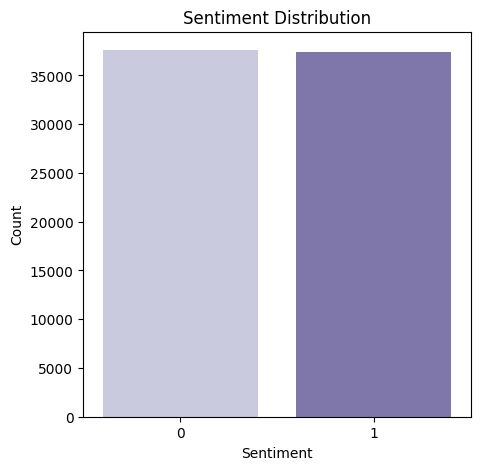

In [ ]:
#### STEP 2: See how many reviews we have of each sentiment
data.sentiment.replace(1, 0, inplace=True)
data.sentiment.replace(2, 1, inplace=True)

# Calculate the count of each sentiment
dist = data.groupby("sentiment").size()

# Create the bar plot
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(x=dist.index, y=dist.values, ax=ax, palette = 'Purples')

# Customize the plot
ax.set_xlabel("Sentiment")
ax.set_ylabel("Count")
ax.set_title("Sentiment Distribution")

# Display the plot
plt.show()

In [ ]:
##### Fer un cop:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
import re
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))


def normalize_text(text):
    # Set all characters to lowercase
    text = text.lower()
    # Remove HTML tags
    text = re.sub('<br />', '', text)
    # Remove URLs
    text = re.sub(r"https\S+|www\S+|http\S+", '', text, flags = re.MULTILINE)
    # Remove all punctuation marks
    text = re.sub(r'[^a-zA-Z0-9\s@#]', '', text)
    # Break text into individual linguistic units
    text_tokens = word_tokenize(text)
    # Remove common words that are considered to be insignificant and reduce words to their base or root form
    filtered_text = [PorterStemmer().stem(w) for w in text_tokens if w not in stop_words]
    return " ".join(filtered_text)

#### STEP 3: Normalize the reviews
data.review = data.review.apply(normalize_text)

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from collections import Counter


# Extract reviews and sentiments from the DataFrame
reviews = data['review'].values
sentiments = data['sentiment'].values

# Hyperparameters
vocab_size = 25000  # Maximum number of unique words in the vocabulary
max_length = 10  # Maximum length of each review sequence
embedding_dim = 100  # Dimensionality of word embeddings

# Tokenize the reviews
# tokenizer = Tokenizer(num_words=vocab_size)
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(reviews)
sequences = tokenizer.texts_to_sequences(reviews)

# Pad sequences to ensure equal length
padded_sequences = pad_sequences(sequences, maxlen=max_length)

# #### STEP 4: Split into train and test
total_train = int(len(padded_sequences) * 0.75)
total_test = int(len(padded_sequences) * 0.25)

train_data_review = padded_sequences[:total_train]
test_data_review = padded_sequences[total_train:]

train_data_sentiment = sentiments[:total_train]
test_data_sentiment = sentiments[total_train:]

In [ ]:
#### STEP 6: Convert the data to tensors
# train_data_review = np.hstack((train_data_review.reshape(-1, 1), train_data_sentiment.reshape(-1, 1)))
train_r_tensor = torch.FloatTensor(train_data_review)
train_s_tensor = torch.FloatTensor(train_data_sentiment)

test_r_tensor = torch.FloatTensor(train_data_review)
test_s_tensor = torch.FloatTensor(train_data_sentiment)

# Create PyTorch datasets
train_dataset = TensorDataset(train_r_tensor, train_s_tensor)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# print(train_r_tensor)

In [ ]:
# Training loop
def train(train_loader, criterion, optimizer, model, num_epochs):
 list_loss = []
 total_step = len(train_loader)
 for epoch in range(num_epochs):
   temp = []
   for i, (inputs, labels) in enumerate(train_loader):
       # Forward pass
       inputs = inputs.long()
       outputs = model(inputs)
       outputs = torch.sigmoid(outputs)  # Apply sigmoid activation
       loss = criterion(outputs, labels.unsqueeze(1))
       # Backward and optimize
       optimizer.zero_grad()
       loss.backward()
       optimizer.step()
       temp.append(loss.item())
   if epoch == 0:
     print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch, num_epochs, temp[0])) # Print the initial loss
   l = min(temp)
   print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, l)) # Print the loss in each epoch
   list_loss.append(l)
 return list_loss

def test(model, test_data, test_labels):
   model.eval()
   with torch.no_grad():
       outputs = model(test_data.long())
       predicted = (outputs > 0.5).float()
       accuracy = (predicted == test_labels.unsqueeze(1)).sum().item() / len(test_labels)
       print('Test Accuracy of the model: {} %'.format(accuracy * 100))

In [ ]:
class MobNet(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim,
                 dropout, pad_idx):

        super().__init__()

        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx = pad_idx)

        num_layers = 2
        new_dim = int(embedding_dim / num_layers)

        self.full = nn.ModuleList([
            nn.Conv2d(in_channels = 1,
                      out_channels = n_filters,
                      kernel_size = (fs, embedding_dim))
            for fs in filter_sizes
            ])

        self.depthwise = nn.ModuleList([
            nn.Conv2d(in_channels = n_filters,
                      out_channels = n_filters,
                      kernel_size = (fs, 1),
                      groups = 1)
            for fs in filter_sizes
            ])

        self.bn = nn.BatchNorm2d(n_filters)
        self.pointwise = nn.Conv2d(n_filters, n_filters, kernel_size = 1)

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
        self.avgpool = nn.AvgPool2d(kernel_size=4, stride=2)

    def depthwise_separable_convolution(self, embedded, fconv, dconv):

      out = F.relu(self.bn(fconv(embedded)))

      out = F.relu(self.bn(dconv(out)))
      return F.relu(self.bn(self.pointwise(out))).squeeze(3)

    def forward(self, x):

        embedded = self.embedding(x)

        embedded = embedded.unsqueeze(1)

        conved = [self.depthwise_separable_convolution(embedded, self.full[i], self.depthwise[i]) for i in range(len(self.full))]

        pooled = [F.avg_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]

        cat = self.dropout(torch.cat(pooled, dim = 1))

        return self.fc(cat)

Epoch [0/20], Loss: 0.6551
Epoch [1/20], Loss: 0.2253
Epoch [2/20], Loss: 0.1447
Epoch [3/20], Loss: 0.0842
Epoch [4/20], Loss: 0.0288
Epoch [5/20], Loss: 0.0115
Epoch [6/20], Loss: 0.0024
Epoch [7/20], Loss: 0.0021
Epoch [8/20], Loss: 0.0008
Epoch [9/20], Loss: 0.0004
Epoch [10/20], Loss: 0.0007
Epoch [11/20], Loss: 0.0005
Epoch [12/20], Loss: 0.0002
Epoch [13/20], Loss: 0.0002
Epoch [14/20], Loss: 0.0002
Epoch [15/20], Loss: 0.0002
Epoch [16/20], Loss: 0.0001
Epoch [17/20], Loss: 0.0001
Epoch [18/20], Loss: 0.0000
Epoch [19/20], Loss: 0.0000
Epoch [20/20], Loss: 0.0000


Text(0, 0.5, 'Loss Val')

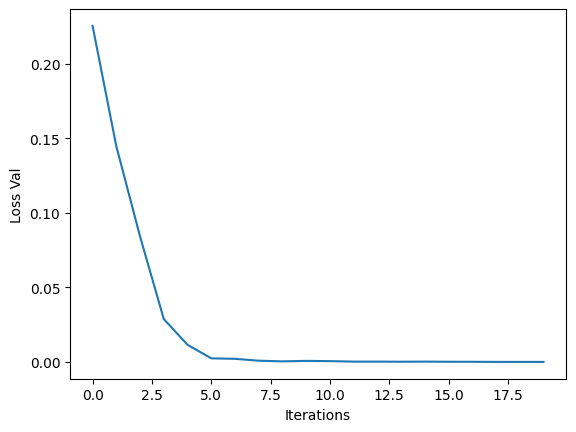

In [ ]:
#### STEP 8: # Instantiate the models
embedding_dim = 100
n_filters = 100
filter_sizes = [3, 4, 5]
output_dim = 1
dropout = 0.5
pad_idx = tokenizer.word_index['<OOV>']

model = MobNet(vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, pad_idx)

# Define the loss function
criterion = nn.BCELoss()

# Define the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)

#### STEP 9: Train the model

list_loss = train(train_loader, criterion, optimizer, model, num_epochs = 20)
plt.plot(list_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss Val')

In [ ]:
#### STEP 10: Evaluate the model
accuracy = test(model, test_r_tensor, test_s_tensor)

Test Accuracy of the model: 97.93066666666667 %


In [ ]:
#### Step 11: Test our model with a new user input
import spacy
nlp = spacy.load('en_core_web_sm')


def predict_sentiment(model, sentence):
   model.eval()
   # Text normalization and tokenization
   text = normalize_text(sentence)
   sequence = tokenizer.texts_to_sequences([text])
   padded_sequence = pad_sequences(sequence, maxlen=max_length)
   r_tensor = torch.LongTensor(padded_sequence)
   # Perform the prediction
   with torch.no_grad():
       prediction = model(r_tensor)
   prediction = torch.sigmoid(prediction)
   # Determine the sentiment based on the prediction
   if prediction.item() > 0.5:
       sentiment = 'Positive'
   else:
       sentiment = 'Negative'
   return sentiment, prediction.item()


review = "Horrible, terrible, don't go there."
result, score = predict_sentiment(model, review)
print("Review:", review)
print(f"Predicted Sentiment: {result}, {score}")
print("\n")
review = "Amazing, I love this place!"
result, score = predict_sentiment(model, review)
print("Review:", review)
print(f"Predicted Sentiment: {result}, {score}")


Review: Horrible, terrible, don't go there.
Predicted Sentiment: Negative, 4.0485778618482016e-10


Review: Amazing, I love this place!
Predicted Sentiment: Positive, 1.0
